In [1]:
import numpy as np
import pandas as pd

from pycaret.datasets import get_data
from pycaret.classification import *

from library.sb_utils import save_file

In [2]:
df = get_data('EDA')

,customerId,transactionDateTime,transactionType,creditLimit,availableMoney,transactionAmount,currentBalance,merchantName,merchantCategoryCode,acqCountry,posEntryMode,posConditionCode,accountOpenDate,dateOfLastAddressChange,cardPresent,expirationDateKeyInMatch,Incorrect CVV Entered,isFraud,month,day_of_month,begin_of_month,middle_of_month,end_of_month,day_of_week,hour,morning,day,evening,night,weekday,weekend,time_of_day,time_of_month,holiday,time_since_last_transaction,differ_from_last_transaction_amount,transactionAmt_avg,avg_diff,changedAddress,encoded_currentExpDate,cardLast4Digits_counts,encoded_cardLast4Digits
0,737265056,2016-08-13 14:27:32,PURCHASE,5000,5000.0,98.55,0.0,Other,rideshare,US,2,1,735671,735671,0,0,0,0,8,13,0,1,0,Saturday,14,0,1,0,0,0,1,day,middle,0,0.0,0.00,98.55,0.0,0,42,2,949
1,737265056,2016-10-11 05:05:54,PURCHASE,5000,5000.0,74.51,0.0,Other,entertainment,US,9,1,735671,735671,1,0,0,0,10,11,0,1,0,Tuesday,5,0,0,0,1,1,0,night,middle,0,5063902.0,-24.04,74.51,0.0,0,50,2,395
2,737265056,2016-11-08 09:18:39,PURCHASE,5000,5000.0,7.47,0.0,Other,Other,US,9,1,735671,735671,0,0,0,0,11,8,1,0,0,Tuesday,9,1,0,0,0,1,0,morning,beginning,0,2434365.0,-67.04,7.47,0.0,0,68,2,395
3,737265056,2016-12-10 02:14:50,PURCHASE,5000,5000.0,7.47,0.0,Other,Other,US,9,1,735671,735671,0,0,0,0,12,10,0,1,0,Saturday,2,0,0,0,1,0,1,night,middle,0,2739371.0,0.00,7.47,0.0,0,68,2,395
4,830329091,2016-03-24 21:04:46,PURCHASE,5000,5000.0,71.18,0.0,Other,fastfood,US,2,1,735816,735816,1,0,0,0,3,24,0,0,1,Thursday,21,0,0,1,0,1,0,evening,end,0,0.0,0.00,71.18,0.0,0,118,1,1663


Before putting the data in a model, lets perform some quick Preprocessing here and turn all features to numerical.  Also drop columns that will not be ustilized by the models.

In [3]:
#Drop some features

df.drop(columns=['customerId','transactionDateTime','time_of_day','time_of_month'],inplace=True)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 776491 entries, 0 to 776490
Data columns (total 38 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   transactionType                      776491 non-null  object 
 1   creditLimit                          776491 non-null  int64  
 2   availableMoney                       776491 non-null  float64
 3   transactionAmount                    776491 non-null  float64
 4   currentBalance                       776491 non-null  float64
 5   merchantName                         776491 non-null  object 
 6   merchantCategoryCode                 776491 non-null  object 
 7   acqCountry                           776491 non-null  object 
 8   posEntryMode                         776491 non-null  int64  
 9   posConditionCode                     776491 non-null  int64  
 10  accountOpenDate                      776491 non-null  int64  
 11  dateOfLastAdd

In [5]:
#Get dummy variables on the rest of the object features

df = pd.get_dummies(df)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 776491 entries, 0 to 776490
Columns: 101 entries, creditLimit to day_of_week_Wednesday
dtypes: float64(7), int64(26), uint8(68)
memory usage: 245.9 MB


This is a large dataset and running this through several models will take up some time.  We can help remedy this by turning 64 bits into 32 bits

In [6]:
#lets reduce the memory by turning 64 bits into 32 bit

#create a list for all int64 and float64
int_ = list(df.select_dtypes('int64').columns)
float_ = list(df.select_dtypes('float64').columns)

print('Before: ',df.dtypes.unique())

#take care of int64 first
for i in int_:
    df[i]=df[i].astype('int32')
    
#then float64

for f in float_:
    df[f] = df[f].astype('float32')
    
print('After: ',df.dtypes.unique())

Before:  [dtype('int64') dtype('float64') dtype('uint8')]
After:  [dtype('int32') dtype('float32') dtype('uint8')]


We've decreased memory usage from 245.9 MP to 148.1 MP, near a 40% decrease.  Well worth it.

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 776491 entries, 0 to 776490
Columns: 101 entries, creditLimit to day_of_week_Wednesday
dtypes: float32(7), int32(26), uint8(68)
memory usage: 148.1 MB


It is finally time to model!

# Pycaret Classification

For the modeling process, we will be using **Pycaret Classification**.

Pycaret Classification allows us to setup different algorithms and use it for several different classification models to determine the best performing model.

After *setup* of the environment, we can see that we originally had 102 features but after removing the target feature, it also removed one other feature, perhaps a useless feature.  Then it transformed into a seperate train/test set to be used by the models.

In [10]:
#set up environment in Pycaret

clf = setup(data = df, target = 'isFraud',session_id=123)

,Description,Value
0,session_id,123
1,Target,isFraud
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(776491, 101)"
5,Missing Values,False
6,Numeric Features,100
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


In comparing models for a large unbalanced data set, the *Accuracy* score will generally be really high, but that doesn't show the true performance of the model.  

*AUC* score is the better evaluation method for this type of data, so we'll be sorting and deciding the best models based on that score

In [11]:
#compare models

compare_models(sort='auc',fold=5)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
catboost,CatBoost Classifier,0.9860,0.8400,0.1050,0.8803,0.1876,0.1849,0.3013,78.5280
lightgbm,Light Gradient Boosting Machine,0.9853,0.8350,0.0755,0.6983,0.1361,0.1335,0.2262,3.8080
xgboost,Extreme Gradient Boosting,0.9856,0.8306,0.0765,0.8382,0.1402,0.1380,0.2506,53.1460
gbc,Gradient Boosting Classifier,0.9849,0.8011,0.0256,0.7557,0.0494,0.0485,0.1366,81.3980
rf,Random Forest Classifier,0.9851,0.7824,0.0327,0.9848,0.0632,0.0623,0.1778,58.6440
ada,Ada Boost Classifier,0.9846,0.7700,0.0000,0.0000,0.0000,0.0000,0.0000,25.5100
et,Extra Trees Classifier,0.9852,0.7525,0.0409,0.9721,0.0785,0.0774,0.1978,70.4040
lda,Linear Discriminant Analysis,0.9816,0.7330,0.0267,0.1110,0.0425,0.0366,0.0467,5.1640
lr,Logistic Regression,0.9846,0.6533,0.0000,0.0000,0.0000,-0.0000,-0.0001,9.3000
nb,Naive Bayes,0.9473,0.6480,0.1096,0.0415,0.0602,0.0387,0.0436,1.3320


With just a couple line of codes, we were able to see the results of 15 models.  The AUC scores were quite impressive too for such a large and imbalanced dataset.

Next we are going to use the top 3 models and *blend* them together to make a new model

This blended model performs slightly better than the other 3 but not significantly better

In [12]:
#Locate the top 3

top_3 = compare_models(n_select = 3, include = ['xgboost','lightgbm','catboost'])

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
catboost,CatBoost Classifier,0.9861,0.8432,0.1078,0.8832,0.1920,0.1893,0.3056,83.8620
xgboost,Extreme Gradient Boosting,0.9857,0.8346,0.0872,0.8267,0.1575,0.1550,0.2652,66.5080
lightgbm,Light Gradient Boosting Machine,0.9854,0.8372,0.0788,0.7169,0.1418,0.1392,0.2341,3.3170


In [13]:
#blend them 

blender = blend_models(top_3, choose_better = True, optimize='AUC')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9860,0.8502,0.0969,0.9310,0.1755,0.1731,0.2979
1,0.9857,0.8515,0.0921,0.8280,0.1658,0.1632,0.2734
2,0.9858,0.8525,0.0860,0.9114,0.1572,0.1550,0.2776
3,0.9859,0.8394,0.0921,0.9277,0.1676,0.1653,0.2899
4,0.9860,0.8574,0.1005,0.9231,0.1812,0.1787,0.3021
5,0.9857,0.8493,0.0837,0.8537,0.1525,0.1502,0.2648
6,0.9857,0.8534,0.0789,0.8919,0.1451,0.1429,0.2630
7,0.9858,0.8558,0.0837,0.9211,0.1535,0.1513,0.2754
8,0.9856,0.8395,0.0742,0.9118,0.1372,0.1352,0.2578
9,0.9859,0.8497,0.0873,0.9359,0.1597,0.1575,0.2836


Now create the other models seperately

In [14]:
catboost = create_model('catboost')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9861,0.8462,0.1112,0.9029,0.1981,0.1954,0.3143
1,0.9861,0.8403,0.1136,0.8636,0.2008,0.1980,0.3104
2,0.9859,0.8470,0.1016,0.8416,0.1812,0.1785,0.2895
3,0.9860,0.8345,0.1089,0.8505,0.1930,0.1902,0.3014
4,0.9862,0.8477,0.1208,0.8860,0.2126,0.2097,0.3243
5,0.9861,0.8441,0.1065,0.9175,0.1908,0.1882,0.3100
6,0.9861,0.8522,0.1089,0.9192,0.1947,0.1920,0.3137
7,0.9859,0.8463,0.1041,0.8529,0.1855,0.1828,0.2951
8,0.9859,0.8307,0.0945,0.8977,0.1710,0.1686,0.2887
9,0.9861,0.8430,0.1077,0.9000,0.1923,0.1896,0.3086


In [15]:
xgboost = create_model('xgboost')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9859,0.8361,0.1077,0.8257,0.1905,0.1876,0.2952
1,0.9856,0.8326,0.0897,0.7979,0.1613,0.1587,0.2647
2,0.9856,0.8377,0.0872,0.8022,0.1573,0.1548,0.2617
3,0.9858,0.8255,0.0861,0.9231,0.1575,0.1553,0.2796
4,0.9859,0.8450,0.1005,0.8400,0.1795,0.1768,0.2877
5,0.9855,0.8319,0.0885,0.7327,0.1580,0.1551,0.2515
6,0.9856,0.8392,0.0813,0.8193,0.1480,0.1456,0.2555
7,0.9856,0.8378,0.0813,0.8500,0.1485,0.1462,0.2604
8,0.9855,0.8289,0.0694,0.8286,0.1280,0.1260,0.2373
9,0.9856,0.8315,0.0801,0.8481,0.1464,0.1442,0.2582


In [16]:
lgbm = create_model('lightgbm')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9856,0.8387,0.0873,0.7766,0.1570,0.1544,0.2575
1,0.9854,0.8374,0.0849,0.7100,0.1517,0.1489,0.2423
2,0.9855,0.8415,0.0908,0.7451,0.1619,0.1591,0.2570
3,0.9853,0.8213,0.0718,0.7317,0.1307,0.1283,0.2263
4,0.9856,0.8447,0.0945,0.7453,0.1677,0.1648,0.2622
5,0.9851,0.8395,0.0586,0.6622,0.1077,0.1055,0.1941
6,0.9853,0.8373,0.0849,0.6698,0.1507,0.1478,0.2351
7,0.9855,0.8479,0.0801,0.7614,0.1450,0.1425,0.2441
8,0.9853,0.8259,0.0646,0.7397,0.1188,0.1166,0.2159
9,0.9851,0.8374,0.0706,0.6277,0.1269,0.1242,0.2071


Pycaret's *tune_model()* function performs a random grid search of parameters to try and improve the score set by its *optimize* arguement.

We are going to create tuned models of the 3 previous models

In [17]:
tuned_cat = tune_model(catboost,optimize='auc')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9855,0.8048,0.0586,1.0000,0.1107,0.1092,0.2403
1,0.9853,0.7947,0.0478,0.9756,0.0912,0.0899,0.2144
2,0.9855,0.8125,0.0573,1.0000,0.1085,0.1070,0.2377
3,0.9855,0.7884,0.0586,1.0000,0.1107,0.1092,0.2403
4,0.9856,0.8118,0.0634,0.9815,0.1191,0.1175,0.2476
5,0.9854,0.7935,0.0526,1.0000,0.1000,0.0986,0.2277
6,0.9854,0.7996,0.0490,1.0000,0.0935,0.0922,0.2198
7,0.9854,0.8070,0.0538,1.0000,0.1022,0.1007,0.2303
8,0.9853,0.7980,0.0467,1.0000,0.0891,0.0879,0.2144
9,0.9853,0.8045,0.0478,0.9756,0.0912,0.0899,0.2144


In [18]:

tuned_xgboost = tune_model(xgboost,optimize='auc')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8273,0.8283,0.6495,0.0563,0.1037,0.0776,0.1545
1,0.8326,0.8220,0.6507,0.0582,0.1068,0.0808,0.1585
2,0.8315,0.8281,0.6344,0.0566,0.1039,0.0778,0.1528
3,0.8284,0.8126,0.6148,0.0540,0.0993,0.0731,0.1446
4,0.8332,0.8341,0.6495,0.0583,0.1070,0.0810,0.1586
5,0.8281,0.8223,0.6423,0.0560,0.1031,0.0770,0.1528
6,0.8283,0.8319,0.6447,0.0563,0.1035,0.0774,0.1537
7,0.8315,0.8349,0.6591,0.0585,0.1074,0.0815,0.1604
8,0.8302,0.8200,0.6244,0.0553,0.1016,0.0755,0.1488
9,0.8292,0.8257,0.6268,0.0552,0.1015,0.0753,0.1488


In [19]:

tuned_lgbm = tune_model(lgbm,optimize='auc')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9854,0.8323,0.0598,0.9091,0.1122,0.1105,0.2311
1,0.9852,0.8337,0.0562,0.7705,0.1048,0.1029,0.2057
2,0.9854,0.8266,0.0609,0.8947,0.1141,0.1124,0.2314
3,0.9855,0.8194,0.0646,0.8710,0.1203,0.1184,0.2349
4,0.9855,0.8324,0.0634,0.8833,0.1183,0.1165,0.2345
5,0.9854,0.8292,0.0526,0.9167,0.0995,0.0980,0.2177
6,0.9852,0.8340,0.0443,0.8409,0.0841,0.0827,0.1909
7,0.9854,0.8370,0.0538,0.9000,0.1016,0.1000,0.2181
8,0.9853,0.8220,0.0478,0.9302,0.0910,0.0896,0.2092
9,0.9852,0.8297,0.0443,0.8409,0.0841,0.0827,0.1909


# Predictions

Use models *predict_model* to predict on the test set and visualize their confusion matrix

In [20]:
pred_cat = predict_model(catboost)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,CatBoost Classifier,0.9861,0.8401,0.1055,0.8724,0.1882,0.1855,0.3006


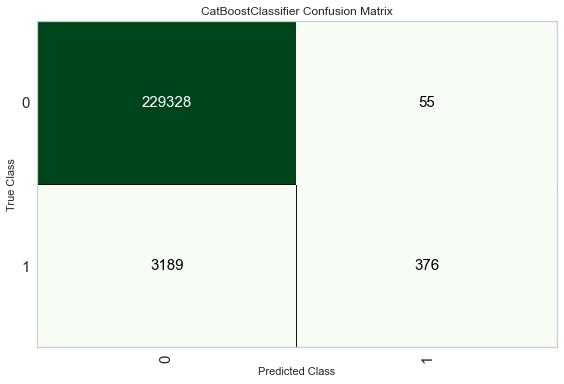

In [42]:
plot_model(catboost, plot = 'confusion_matrix')

In [21]:
pred_xgboost = predict_model(xgboost)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extreme Gradient Boosting,0.9856,0.8359,0.0822,0.7962,0.1490,0.1466,0.2530


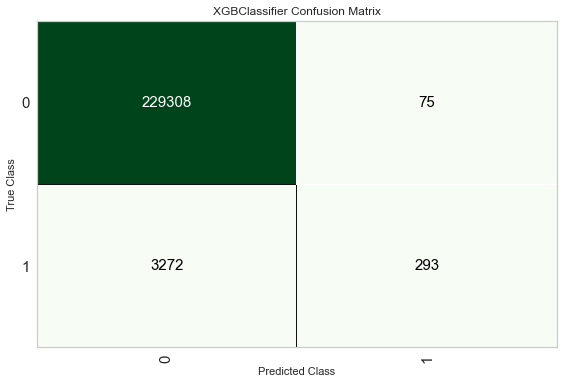

In [43]:
plot_model(xgboost, plot = 'confusion_matrix')

In [22]:
pred_lgbm = predict_model(lgbm)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.9853,0.8377,0.0777,0.6756,0.1394,0.1366,0.2259


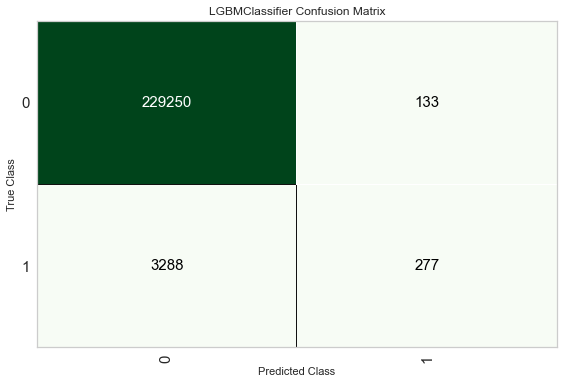

In [44]:
plot_model(lgbm, plot = 'confusion_matrix')

In [40]:
pred_blender = predict_model(blender)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Voting Classifier,0.9859,0.8486,0.0878,0.9046,0.1601,0.1578,0.2794


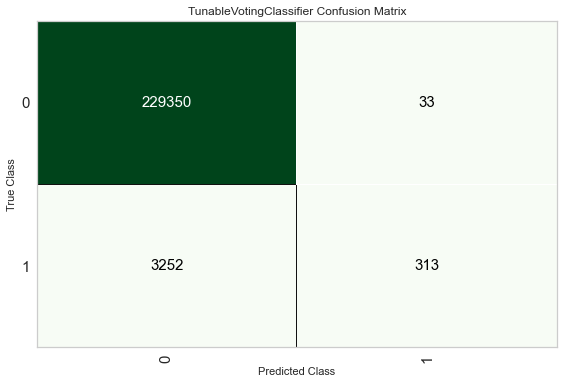

In [45]:
plot_model(blender, plot = 'confusion_matrix')

Predictions using the tuned models proved less affective

In [23]:
tuned_cat_predict = predict_model(tuned_cat)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,CatBoost Classifier,0.9856,0.7937,0.0561,0.9950,0.1062,0.1048,0.2345


In [24]:
tuned_xgboost_predict = predict_model(tuned_xgboost)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extreme Gradient Boosting,0.8258,0.8216,0.6412,0.0550,0.1013,0.0752,0.1506


In [25]:
tuned_lgbm_predict = predict_model(tuned_lgbm)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.9855,0.8298,0.0544,0.9327,0.1028,0.1013,0.2234


# Feature Importance

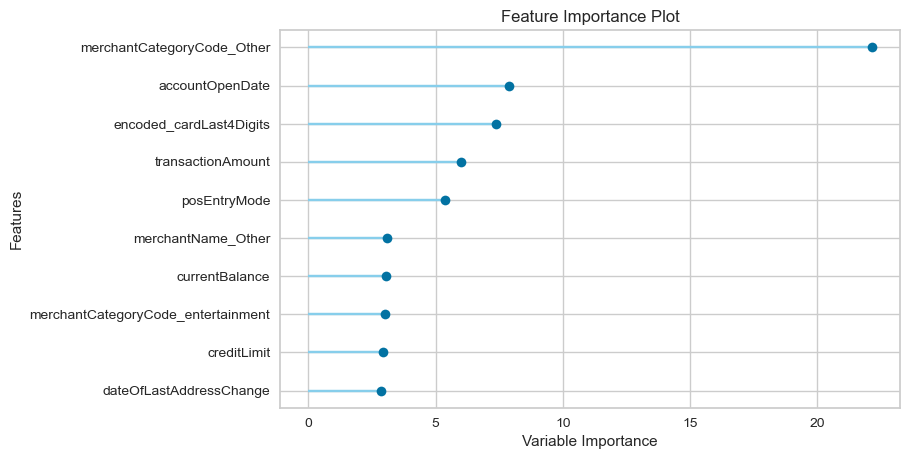

In [26]:
plot_model(catboost, plot = 'feature')

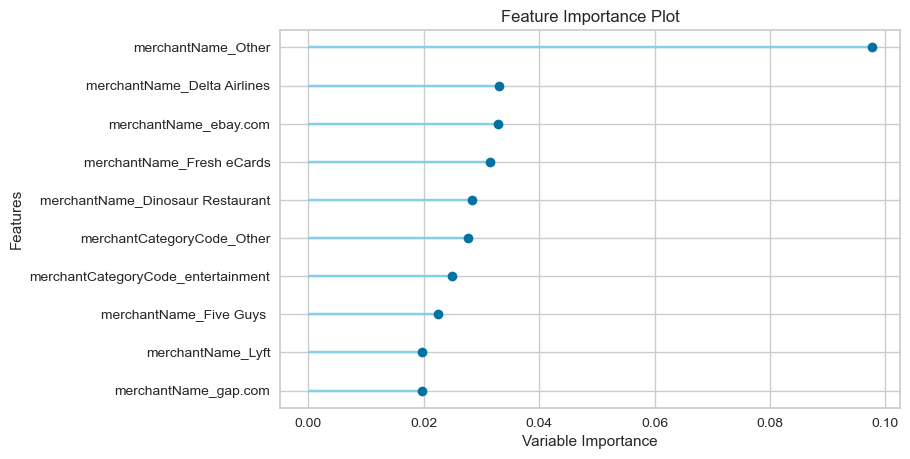

In [27]:
plot_model(xgboost, plot = 'feature')

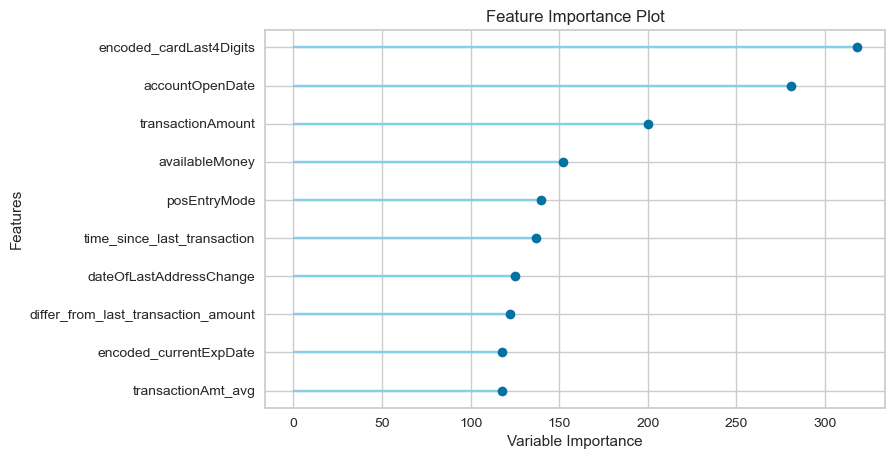

In [28]:
plot_model(lgbm, plot = 'feature')

# Evaluation

The top 3 performing models were Catboost, Xgboost, and Lgbm with similar scores.  The blended model performed slightly better, but tuning it's parameter and plotting feature importance were not possible.  Therefore evaluating performance for the three models separately is more feasible. In attempt to tune parameters through a random grid search, the results actually performed worst than the untuned models.  Even so, they generally scored very similar.  Whats interesting is that these models' top 10 features are mostly different even though they arrive at similar scores.  


- Catboost used the most range of features from original datestimes, transaction amounts, and merchant names/codes.  It was very similar to the Lgbm as they had the same five out of ten features.  Lgbm used more of numeric features and the datetime features, not using much of the merchant's information.  Xgboost was the most different, focusing only on merchant names and category codes.


- There weres some features that appeared in the top 10 for two different models, but no one feature appeared all three times.


- The most noticable appearances and should be further investigated are: 
    - accountOpenDate as the second most important feature for both Catboost and Lgbm
    - transactionAmount as the third most important feature for Catboost and Lgbm
    - encoded_cardLast4Digits as number one for Lgbm and third for Catboost